# Cutting Stocks Problem

## Crucial Libraries

In [1]:
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib.pyplot as plt


## Seed Creation

In [2]:
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

In [3]:
data = {
    'stock_length': 40000,
    'demand_lengths': [1200, 1500, 800, 1000, 750, 2000, 650, 900, 500, 1300],
    'demand_quantities': [20, 30, 15, 25, 10, 18, 22, 17, 35, 12],
}

# genetic algorithm parameters
population_size = 100
num_generations = 100
mutation_rate = 0.01

# Cellular Automata parameters
grid_size = (10, 10)
num_iterations = 100  # Number of iterations for evolution
mutation_probability = 0.03  # Probability of random mutation to maintain diversity
reset_probability = 0.05  # Probability to reset underperforming cells

# Parameters for Ant Colony Optimization
num_ants = 50
num_iterations = 100
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic (demand ratio to length)
evaporation_rate = 0.1  # Rate that pheromone evaporates
pheromone_intensity = 1.0  # Pheromone intensity


## Genetic Algorithms

In [4]:
def initialize_population(pop_size, demand_lengths, stock_length):
    population = []
    for _ in range(pop_size):
        individual = [1] * len(demand_lengths)
        remaining_length = stock_length - sum(demand_lengths)

        if remaining_length < 0:
            individual = [0] * len(demand_lengths)
        else:
            for i, length in enumerate(demand_lengths):
                max_count = remaining_length // length
                count = random.randint(0, max(1, max_count)) if max_count > 0 else 0
                individual[i] += count
                remaining_length -= count * length

        population.append(individual)
    return population

def fitness(individual, demand_lengths, demand_quantities, stock_length):
    total_used = sum([ind * length for ind, length in zip(individual, demand_lengths)])
    if total_used > stock_length:
        return -1000

    unmet_minimum = sum(1 for ind in individual if ind < 1)
    waste = stock_length - total_used
    demand_fulfillment = sum(min(ind, demand) for ind, demand in zip(individual, demand_quantities))
    penalty = sum(max(ind - demand, 0) for ind, demand in zip(individual, demand_quantities))
    fitness_score = demand_fulfillment - 0.1 * waste - 0.5 * penalty - 100 * unmet_minimum
    return max(fitness_score, 0)

def selection(population, fitness_scores):
    min_fitness = min(fitness_scores)
    if min_fitness < 0:
        fitness_scores = [score - min_fitness + 1 for score in fitness_scores]

    total_fitness = sum(fitness_scores)
    if total_fitness == 0:
        selection_probs = [1 / len(population) for _ in population]
    else:
        selection_probs = [score / total_fitness for score in fitness_scores]

    selected_index = np.random.choice(range(len(population)), p=selection_probs)
    return population[selected_index]


def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

def mutate(individual, demand_lengths, stock_length, mutation_rate=0.1):
    if random.random() < mutation_rate:
        index = random.randint(0, len(individual) - 1)
        remaining_length = stock_length - sum([ind * length for ind, length in zip(individual, demand_lengths)])

        max_mutation = max(remaining_length // demand_lengths[index] if demand_lengths[index] != 0 else 0, 0)
        mutation_value = random.randint(0, max_mutation) if max_mutation > 0 else 0
        individual[index] = max(1, individual[index] + mutation_value)

def genetic_algorithm(data, pop_size, generations):
    demand_lengths = data['demand_lengths']
    demand_quantities = data['demand_quantities']
    stock_length = data['stock_length']

    population = initialize_population(pop_size, demand_lengths, stock_length)

    for generation in range(generations):
        fitness_scores = [fitness(individual, demand_lengths, demand_quantities, stock_length) for individual in population]
        new_population = []
        for _ in range(pop_size // 2):
            parent1 = selection(population, fitness_scores)
            parent2 = selection(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            mutate(child1, demand_lengths, stock_length=stock_length)
            mutate(child2, demand_lengths, stock_length=stock_length)

            new_population.extend([child1, child2])

        population = new_population

    best_individual = max(population, key=lambda ind: fitness(ind, demand_lengths, demand_quantities, stock_length))
    best_fitness = fitness(best_individual, demand_lengths, demand_quantities, stock_length)

    return best_individual, best_fitness

best_solution, best_score = genetic_algorithm(data, population_size, num_generations)

print("Best Solution:", best_solution)
print("Best Score (Demand Fulfillment - Waste):", best_score)

Best Solution: [2, 2, 14, 1, 1, 1, 5, 16, 1, 1]
Best Score (Demand Fulfillment - Waste): 24.0


### Genetic Algorithms Experiment

Population Size: 50, Runtime: 0.41127991676330566s, Best Solution: [5, 8, 7, 4, 4, 1, 1, 1, 1, 4], Best Fitness: 21.0
Population Size: 100, Runtime: 1.7713606357574463s, Best Solution: [8, 1, 1, 1, 1, 1, 33, 1, 1, 1], Best Fitness: 12.5
Population Size: 200, Runtime: 6.2624897956848145s, Best Solution: [9, 5, 2, 1, 1, 1, 4, 5, 2, 1], Best Fitness: 0


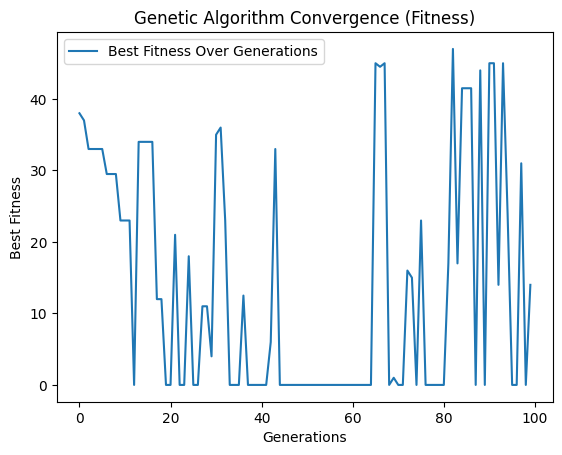

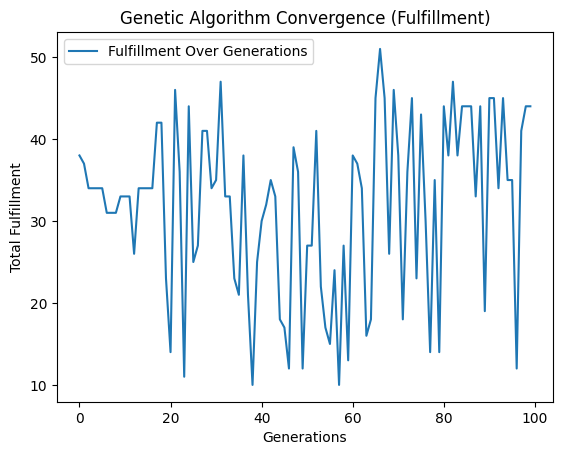

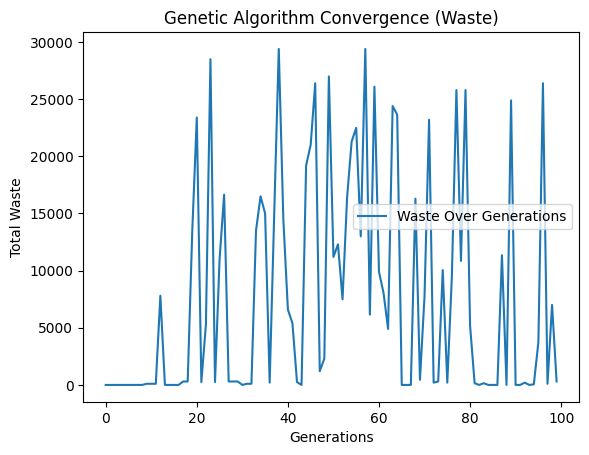

In [5]:
pop_sizes = [50, 100, 200]
genetic_results = []

for pop_size in pop_sizes:
    start_time = time.time()
    best_solution, best_fitness = genetic_algorithm(data, pop_size, num_generations)
    end_time = time.time()
    runtime = end_time - start_time
    genetic_results.append({
        'Population Size': pop_size,
        'Runtime (s)': runtime,
        'Best Solution': best_solution,
        'Best Fitness': best_fitness
    })

for result in genetic_results:
    print(f"Population Size: {result['Population Size']}, Runtime: {result['Runtime (s)']}s, Best Solution: {result['Best Solution']}, Best Fitness: {result['Best Fitness']}")

pop_size = population_size
fitness_over_generations = []
fulfillment_over_generations = []
waste_over_generations = []

population = initialize_population(pop_size, data['demand_lengths'], data['stock_length'])

for generation in range(num_generations):
    fitness_scores = [fitness(individual, data['demand_lengths'], data['demand_quantities'], data['stock_length']) for individual in population]

    best_individual = max(population, key=lambda ind: fitness(ind, data['demand_lengths'], data['demand_quantities'], data['stock_length']))
    best_fitness = fitness(best_individual, data['demand_lengths'], data['demand_quantities'], data['stock_length'])
    fitness_over_generations.append(best_fitness)

    total_used = sum([ind * length for ind, length in zip(best_individual, data['demand_lengths'])])
    total_waste = max(0, data['stock_length'] - total_used)
    total_fulfillment = [min(best_individual[i], data['demand_quantities'][i]) for i in range(len(data['demand_lengths']))]
    fulfillment_over_generations.append(sum(total_fulfillment))
    waste_over_generations.append(total_waste)

    new_population = []
    for _ in range(pop_size // 2):
        parent1 = selection(population, fitness_scores)
        parent2 = selection(population, fitness_scores)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1, data['demand_lengths'], data['stock_length'])
        mutate(child2, data['demand_lengths'], data['stock_length'])
        new_population.extend([child1, child2])
    population = new_population

# Plotting the results over the generations defined
plt.figure()
plt.plot(range(num_generations), fitness_over_generations, label="Best Fitness Over Generations")
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.title("Genetic Algorithm Convergence (Fitness)")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(num_generations), fulfillment_over_generations, label="Fulfillment Over Generations")
plt.xlabel("Generations")
plt.ylabel("Total Fulfillment")
plt.title("Genetic Algorithm Convergence (Fulfillment)")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(num_generations), waste_over_generations, label="Waste Over Generations")
plt.xlabel("Generations")
plt.ylabel("Total Waste")
plt.title("Genetic Algorithm Convergence (Waste)")
plt.legend()
plt.show()


## Cellular Automata

In [6]:
def initialize_grid(grid_size, demand_lengths, stock_length):
    grid = []
    for _ in range(grid_size[0]):
        row = []
        for _ in range(grid_size[1]):
            pattern = [1] * len(demand_lengths)
            remaining_length = stock_length - sum(demand_lengths)

            if remaining_length < 0:
                pattern = [0] * len(demand_lengths)
            else:
                for i, length in enumerate(demand_lengths):
                    max_count = remaining_length // length
                    count = random.randint(0, max(1, max_count)) if max_count > 0 else 0
                    pattern[i] += count
                    remaining_length -= count * length

            row.append(pattern)
        grid.append(row)
    return grid

def fitness(pattern, demand_lengths, demand_quantities, stock_length):
    total_used = sum([p * l for p, l in zip(pattern, demand_lengths)])
    if total_used > stock_length:
        return -1000
    unmet_minimum = sum(1 for p in pattern if p < 1)
    waste = max(stock_length - total_used, 0)
    demand_fulfillment = sum(min(p, q) for p, q in zip(pattern, demand_quantities))
    unmet_penalty = sum(1 for p, q in zip(pattern, demand_quantities) if p < q) * 0.1
    return demand_fulfillment - 0.1 * waste - unmet_penalty - 100 * unmet_minimum

def mutate(individual, demand_lengths, demand_quantities, stock_length):
    index = random.randint(0, len(individual) - 1)
    if individual[index] < demand_quantities[index]:
        remaining_length = stock_length - sum([ind * length for ind, length in zip(individual, demand_lengths)])
        max_add = max(0, remaining_length // demand_lengths[index]) if demand_lengths[index] != 0 else 0
        mutation_value = random.randint(0, max_add)
        individual[index] = max(1, min(demand_quantities[index], individual[index] + mutation_value))

def update_grid(grid, demand_lengths, demand_quantities, stock_length, mutation_probability, reset_probability, iteration, num_iterations):
    current_reset_probability = reset_probability * (1 - iteration / num_iterations)
    adaptive_mutation_probability = mutation_probability * (1 + 0.1 * (1 - iteration / num_iterations))

    new_grid = []
    for i, row in enumerate(grid):
        new_row = []
        for j, cell in enumerate(row):
            if random.random() < current_reset_probability:
                new_pattern = initialize_grid((1, 1), demand_lengths, stock_length)[0][0]
            else:
                neighbors = []
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < len(grid) and 0 <= nj < len(grid[0]):
                        neighbors.append(grid[ni][nj])
                current_fitness = fitness(cell, demand_lengths, demand_quantities, stock_length)
                best_neighbor = max(neighbors, key=lambda n: fitness(n, demand_lengths, demand_quantities, stock_length))
                best_neighbor_fitness = fitness(best_neighbor, demand_lengths, demand_quantities, stock_length)

                new_pattern = best_neighbor[:] if best_neighbor_fitness > current_fitness else cell[:]
                if random.random() < adaptive_mutation_probability:
                    mutate(new_pattern, demand_lengths, demand_quantities, stock_length)

            new_row.append(new_pattern)
        new_grid.append(new_row)
    return new_grid


def cellular_automata(data, grid_size, num_iterations, mutation_probability, reset_probability):
    demand_lengths = data['demand_lengths']
    demand_quantities = data['demand_quantities']
    stock_length = data['stock_length']
    grid = initialize_grid(grid_size, demand_lengths, stock_length)

    for iteration in range(num_iterations):
        grid = update_grid(grid, demand_lengths, demand_quantities, stock_length, mutation_probability, reset_probability, iteration, num_iterations)

    best_patterns = [pattern for row in grid for pattern in row if fitness(pattern, demand_lengths, demand_quantities, stock_length) > 0]
    total_fulfillment = [0] * len(demand_lengths)
    total_waste = 0
    for pattern in best_patterns:
        total_used = sum([p * l for p, l in zip(pattern, demand_lengths)])
        total_waste += max(0, stock_length - total_used)
        for i in range(len(demand_lengths)):
            total_fulfillment[i] += min(pattern[i], demand_quantities[i])
    total_fulfillment = [min(f, q) for f, q in zip(total_fulfillment, demand_quantities)]

    return best_patterns, total_fulfillment, total_waste

best_patterns, total_fulfillment, total_waste = cellular_automata(data, grid_size, num_iterations, mutation_probability, reset_probability)

print("Best Patterns:", best_patterns)
print("Total Fulfillment:", total_fulfillment)
print("Total Waste:", total_waste)

Best Patterns: [[6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1, 1], [6, 3, 2, 14, 6, 1, 4, 2, 1

### Cellular Automata Experiment

Grid Size: (5, 5), Runtime: 0.10133552551269531s, Total Fulfillment: [20, 25, 15, 25, 10, 18, 22, 17, 35, 12], Total Waste: 0
Grid Size: (10, 10), Runtime: 0.7160320281982422s, Total Fulfillment: [20, 30, 15, 25, 10, 18, 22, 17, 35, 12], Total Waste: 0
Grid Size: (20, 20), Runtime: 4.011669635772705s, Total Fulfillment: [20, 30, 15, 25, 10, 18, 22, 17, 35, 12], Total Waste: 0


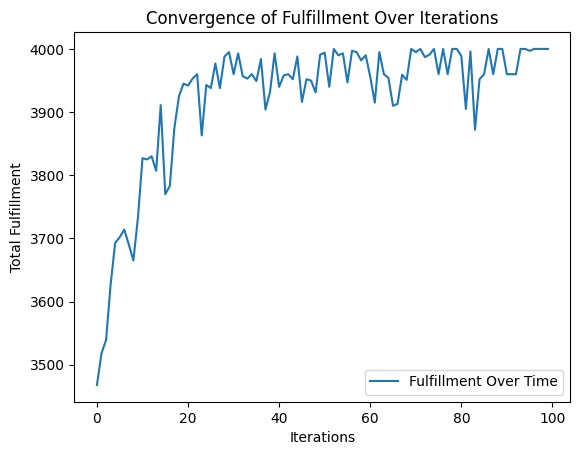

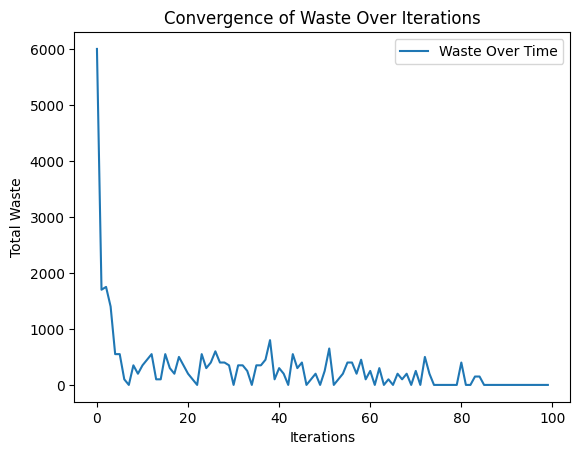

In [7]:
grid_sizes = [(5, 5), (10, 10), (20, 20)]
results = []

for size in grid_sizes:
    start_time = time.time()
    best_patterns, fulfillment, waste = cellular_automata(data, size, num_iterations=100, mutation_probability=0.1, reset_probability=0.05)
    end_time = time.time()
    runtime = end_time - start_time
    results.append({
        'Grid Size': size,
        'Runtime (s)': runtime,
        'Total Fulfillment': fulfillment,
        'Total Waste': waste
    })

for result in results:
    print(f"Grid Size: {result['Grid Size']}, Runtime: {result['Runtime (s)']}s, Total Fulfillment: {result['Total Fulfillment']}, Total Waste: {result['Total Waste']}")

fulfillment_over_time = []
waste_over_time = []

grid = initialize_grid(grid_size, data['demand_lengths'], data['stock_length'])

for iteration in range(num_iterations):
    grid = update_grid(grid, data['demand_lengths'], data['demand_quantities'], data['stock_length'], mutation_probability, reset_probability, iteration, num_iterations)

    best_patterns = [pattern for row in grid for pattern in row if fitness(pattern, data['demand_lengths'], data['demand_quantities'], data['stock_length']) > 0]
    fulfillment = sum([min(pattern[i], data['demand_quantities'][i]) for pattern in best_patterns for i in range(len(data['demand_lengths']))])
    waste = sum([max(0, data['stock_length'] - sum([p * l for p, l in zip(pattern, data['demand_lengths'])])) for pattern in best_patterns])

    fulfillment_over_time.append(fulfillment)
    waste_over_time.append(waste)

# Plotting the fulfillment and waste over time
plt.figure()
plt.plot(range(num_iterations), fulfillment_over_time, label="Fulfillment Over Time")
plt.xlabel("Iterations")
plt.ylabel("Total Fulfillment")
plt.title("Convergence of Fulfillment Over Iterations")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(num_iterations), waste_over_time, label="Waste Over Time")
plt.xlabel("Iterations")
plt.ylabel("Total Waste")
plt.title("Convergence of Waste Over Iterations")
plt.legend()
plt.show()


## Ant Colony Algorithm

In [8]:
demand_lengths = data['demand_lengths']
demand_quantities = data['demand_quantities']
stock_length = data['stock_length']

pheromones = np.ones(len(demand_lengths)) * pheromone_intensity

def fitness_ant(solution, demand_lengths, demand_quantities, stock_length):
    if solution[0] == -1000:
        return -1000
    total_used = sum([p * l for p, l in zip(solution, demand_lengths)])
    if total_used > stock_length:
        return -1000
    unmet_minimum = sum(1 for p in solution if p < 1)
    waste = max(stock_length - total_used, 0)
    demand_fulfillment = sum(min(p, q) for p, q in zip(solution, demand_quantities))
    unmet_penalty = sum(1 for p, q in zip(solution, demand_quantities) if p < q) * 0.1
    return demand_fulfillment - 0.1 * waste - unmet_penalty - 100 * unmet_minimum

def construct_solution(pheromones, demand_lengths, demand_quantities, stock_length):
    solution = [1] * len(demand_lengths)
    remaining_length = stock_length - sum([l for l in demand_lengths])

    if remaining_length < 0:
        return [-1000] * len(demand_lengths)

    while remaining_length > 0:
        probabilities = [(pheromones[i] ** alpha) * ((demand_quantities[i] / demand_lengths[i]) ** beta)
                         if demand_lengths[i] <= remaining_length and solution[i] < demand_quantities[i] else 0
                         for i in range(len(demand_lengths))]
        if sum(probabilities) == 0:
            break

        probabilities = np.array(probabilities) / sum(probabilities)
        chosen_index = np.random.choice(len(demand_lengths), p=probabilities)

        max_possible_count = remaining_length // demand_lengths[chosen_index]
        count = min(max_possible_count, demand_quantities[chosen_index] - solution[chosen_index])
        solution[chosen_index] += count
        remaining_length -= count * demand_lengths[chosen_index]

    return solution


def update_pheromones(pheromones, solutions, fitness_values):
    pheromones *= (1 - evaporation_rate)
    for solution, fitness_value in zip(solutions, fitness_values):
        for i in range(len(solution)):
            pheromones[i] += fitness_value * solution[i] if fitness_value > 0 else 0

def ant_colony_optimization(num_ants, num_iterations, demand_lengths, demand_quantities, stock_length):
    best_solution = None
    best_fitness = float('-inf')

    for iteration in range(num_iterations):
        solutions = [construct_solution(pheromones, demand_lengths, demand_quantities, stock_length) for _ in range(num_ants)]
        fitness_values = [fitness_ant(solution, demand_lengths, demand_quantities, stock_length) for solution in solutions]

        for solution, fitness_value in zip(solutions, fitness_values):
            if fitness_value > best_fitness:
                best_fitness = fitness_value
                best_solution = solution
        update_pheromones(pheromones, solutions, fitness_values)

    total_used = sum([p * l for p, l in zip(best_solution, demand_lengths)])
    total_waste = max(0, stock_length - total_used)
    total_fulfillment = [min(best_solution[i], demand_quantities[i]) for i in range(len(demand_lengths))]

    return best_solution, total_fulfillment, total_waste


best_solution, total_fulfillment, total_waste = ant_colony_optimization(num_ants, num_iterations, demand_lengths, demand_quantities, stock_length)

print("Best Solution:", best_solution)
print("Total Fulfillment:", total_fulfillment)
print("Total Waste:", total_waste)


Best Solution: [2, 1, 15, 1, 1, 1, 1, 1, 35, 1]
Total Fulfillment: [2, 1, 15, 1, 1, 1, 1, 1, 35, 1]
Total Waste: 0


### Ant Colony Optimization Comparison

Num Ants: 25, Runtime: 0.3809850215911865s, Best Solution: [2, 1, 15, 1, 1, 1, 1, 1, 35, 1], Total Fulfillment: [2, 1, 15, 1, 1, 1, 1, 1, 35, 1], Total Waste: 0
Num Ants: 50, Runtime: 0.5957512855529785s, Best Solution: [1, 1, 1, 6, 10, 1, 2, 1, 35, 1], Total Fulfillment: [1, 1, 1, 6, 10, 1, 2, 1, 35, 1], Total Waste: 0
Num Ants: 100, Runtime: 1.7506885528564453s, Best Solution: [1, 1, 1, 6, 10, 1, 2, 1, 35, 1], Total Fulfillment: [1, 1, 1, 6, 10, 1, 2, 1, 35, 1], Total Waste: 0


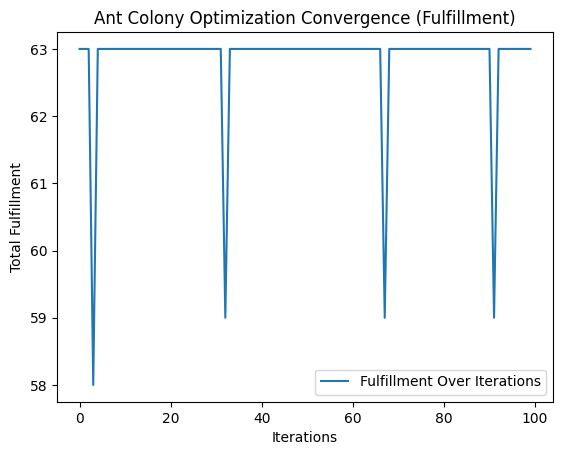

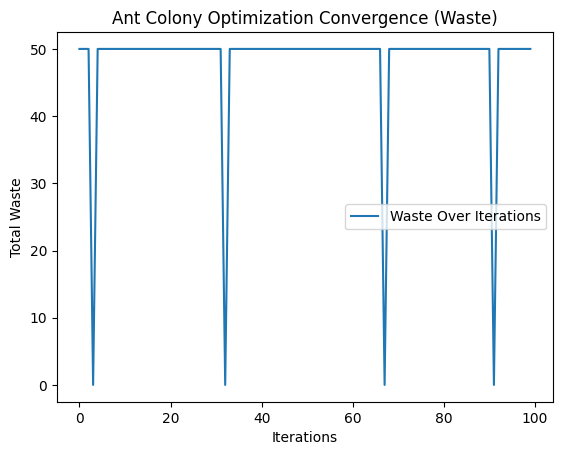

In [9]:
ant_counts = [25, 50, 100]
aco_results = []

for num_ants in ant_counts:
    start_time = time.time()
    best_solution, total_fulfillment, total_waste = ant_colony_optimization(num_ants, num_iterations, data['demand_lengths'], data['demand_quantities'], data['stock_length'])
    end_time = time.time()
    runtime = end_time - start_time
    aco_results.append({
        'Num Ants': num_ants,
        'Runtime (s)': runtime,
        'Best Solution': best_solution,
        'Total Fulfillment': total_fulfillment,
        'Total Waste': total_waste
    })

for result in aco_results:
    print(f"Num Ants: {result['Num Ants']}, Runtime: {result['Runtime (s)']}s, Best Solution: {result['Best Solution']}, Total Fulfillment: {result['Total Fulfillment']}, Total Waste: {result['Total Waste']}")

fulfillment_over_iterations = []
waste_over_iterations = []
pheromones = np.ones(len(data['demand_lengths'])) * pheromone_intensity

for iteration in range(num_iterations):
    solutions = [construct_solution(pheromones, data['demand_lengths'], data['demand_quantities'], data['stock_length']) for _ in range(num_ants)]
    fitness_values = [fitness_ant(solution, data['demand_lengths'], data['demand_quantities'], data['stock_length']) for solution in solutions]

    best_solution = max(solutions, key=lambda sol: fitness_ant(sol, data['demand_lengths'], data['demand_quantities'], data['stock_length']))
    total_used = sum([p * l for p, l in zip(best_solution, data['demand_lengths'])])
    total_waste = max(0, data['stock_length'] - total_used)
    total_fulfillment = [min(best_solution[i], data['demand_quantities'][i]) for i in range(len(data['demand_lengths']))]

    fulfillment_over_iterations.append(sum(total_fulfillment))
    waste_over_iterations.append(total_waste)

    update_pheromones(pheromones, solutions, fitness_values)

# Plotting fulfillment and waste over iterations for ACO
plt.figure()
plt.plot(range(num_iterations), fulfillment_over_iterations, label="Fulfillment Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Total Fulfillment")
plt.title("Ant Colony Optimization Convergence (Fulfillment)")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(num_iterations), waste_over_iterations, label="Waste Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Total Waste")
plt.title("Ant Colony Optimization Convergence (Waste)")
plt.legend()
plt.show()


## Comparison the results

Comparative Results Across Algorithms
                 Algorithm  Runtime (s)  Fulfillment  Waste
0        Genetic Algorithm     1.771361           63     50
1        Cellular Automata     0.716032           63     50
2  Ant Colony Optimization     0.595751           63     50


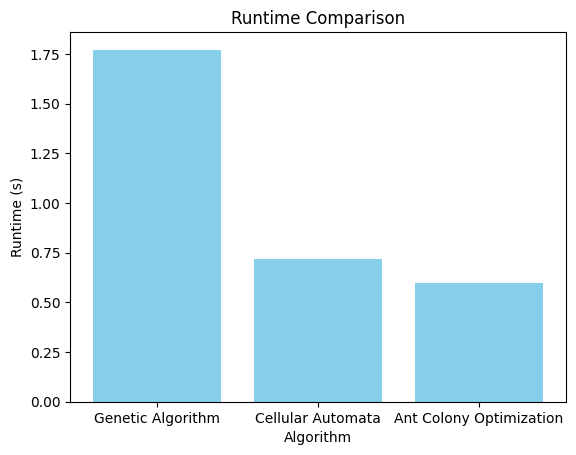

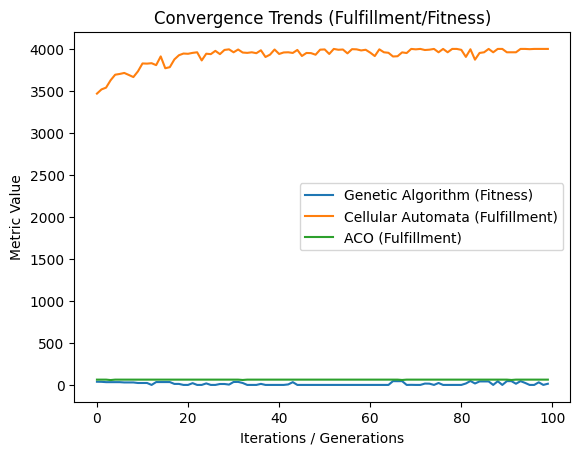

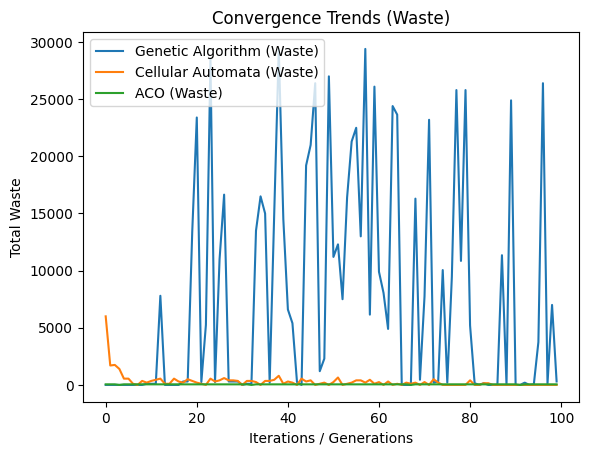

In [11]:
def collect_results():
    # Genetic Algorithm results for 100 population size
    ga_best_solution, ga_fulfillment, ga_waste = best_solution, sum(best_solution), total_waste
    ga_runtime = genetic_results[1]['Runtime (s)']

    # Cellular automata results for 10 * 10 grid
    ca_best_patterns, ca_fulfillment, ca_waste = best_patterns, sum(total_fulfillment), total_waste
    ca_runtime = results[1]['Runtime (s)']

    # Results for 50 ants
    aco_best_solution, aco_fulfillment, aco_waste = best_solution, sum(total_fulfillment), total_waste
    aco_runtime = aco_results[1]['Runtime (s)']

    return [
        {"Algorithm": "Genetic Algorithm", "Runtime (s)": ga_runtime, "Fulfillment": ga_fulfillment, "Waste": ga_waste},
        {"Algorithm": "Cellular Automata", "Runtime (s)": ca_runtime, "Fulfillment": ca_fulfillment, "Waste": ca_waste},
        {"Algorithm": "Ant Colony Optimization", "Runtime (s)": aco_runtime, "Fulfillment": aco_fulfillment, "Waste": aco_waste},
    ]

results = collect_results()
results_df = pd.DataFrame(results)

# Informative table
print("Comparative Results Across Algorithms")
print(results_df)

# Runtime comparisons
plt.figure()
plt.bar(results_df["Algorithm"], results_df["Runtime (s)"], color="skyblue")
plt.xlabel("Algorithm")
plt.ylabel("Runtime (s)")
plt.title("Runtime Comparison")
plt.show()


# Fulfillment trends
plt.figure()
plt.plot(range(num_generations), fitness_over_generations, label="Genetic Algorithm (Fitness)")
plt.plot(range(num_iterations), fulfillment_over_time, label="Cellular Automata (Fulfillment)")
plt.plot(range(num_iterations), fulfillment_over_iterations, label="ACO (Fulfillment)")
plt.xlabel("Iterations / Generations")
plt.ylabel("Metric Value")
plt.title("Convergence Trends (Fulfillment/Fitness)")
plt.legend()
plt.show()

# Waste Trends
plt.figure()
plt.plot(range(num_generations), waste_over_generations, label="Genetic Algorithm (Waste)")
plt.plot(range(num_iterations), waste_over_time, label="Cellular Automata (Waste)")
plt.plot(range(num_iterations), waste_over_iterations, label="ACO (Waste)")
plt.xlabel("Iterations / Generations")
plt.ylabel("Total Waste")
plt.title("Convergence Trends (Waste)")
plt.legend()
plt.show()
